YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step


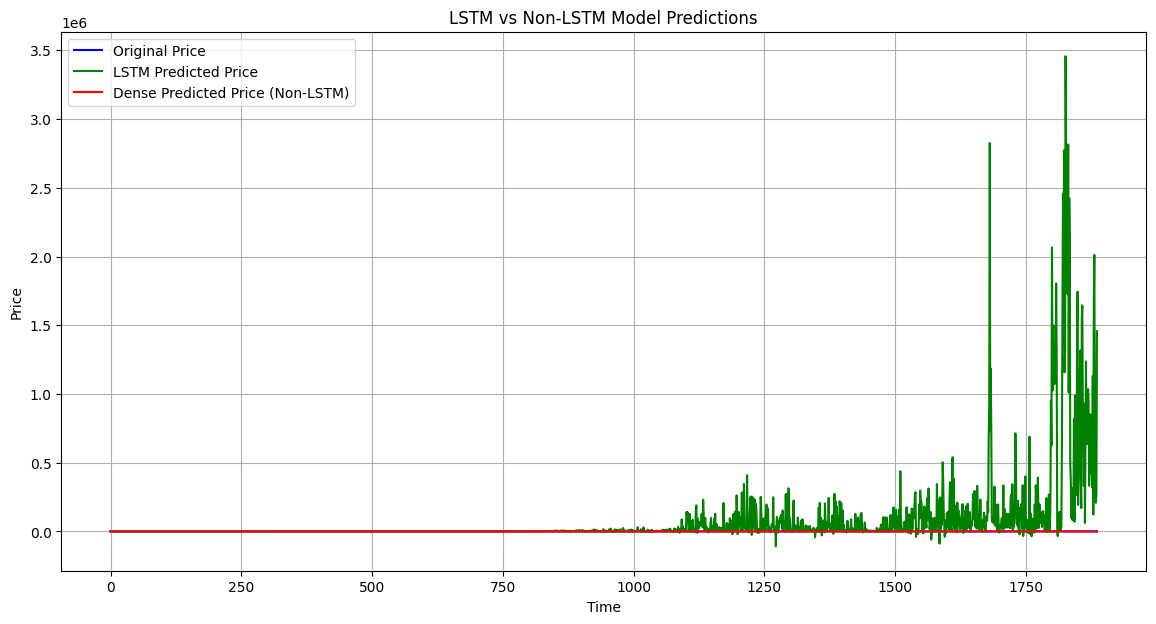

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten

# Fetch stock data
start = '2000-01-01'
end = '2025-01-01'
df = yf.download('AAPL', start=start, end=end)

# Prepare data
df = df.reset_index()
data = df['Close']
data_training = pd.DataFrame(data[0:int(len(data)*0.70)])
data_testing = pd.DataFrame(data[int(len(data)*0.70):])

scaler = MinMaxScaler(feature_range=(0, 1))
data_training_array = scaler.fit_transform(data_training)

# Create training data
x_train, y_train = [], []
for i in range(100, len(data_training_array)):
    x_train.append(data_training_array[i-100:i])
    y_train.append(data_training_array[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

# Create test data
past_100_days = data_training.tail(100)
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)
input_data = scaler.transform(final_df)
x_test, y_test = [], []
for i in range(100, len(input_data)):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i, 0])
x_test = np.array(x_test)
y_test_actual = np.array(y_test)

# ==== 1. LSTM Model ====
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(60, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(80, activation='relu', return_sequences=True),
    Dropout(0.4),
    LSTM(120, activation='relu'),
    Dropout(0.5),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=0)

lstm_predictions = lstm_model.predict(x_test)
lstm_predictions = lstm_predictions * (1 / scaler.scale_[0])
y_test_scaled = y_test_actual * (1 / scaler.scale_[0])

# ==== 2. Dense (Non-LSTM) Model ====
# Flatten x_train for Dense model
x_train_dense = x_train.reshape(x_train.shape[0], -1)
x_test_dense = x_test.reshape(x_test.shape[0], -1)

dense_model = Sequential([
    Dense(128, activation='relu', input_shape=(x_train_dense.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
])
dense_model.compile(optimizer='adam', loss='mean_squared_error')
dense_model.fit(x_train_dense, y_train, epochs=10, batch_size=64, verbose=0)

dense_predictions = dense_model.predict(x_test_dense)
dense_predictions = dense_predictions * (1 / scaler.scale_[0])

# ==== Plotting and Saving ====
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Original Price', color='blue')
plt.plot(lstm_predictions, label='LSTM Predicted Price', color='green')
plt.plot(dense_predictions, label='Dense Predicted Price (Non-LSTM)', color='red')
plt.title('LSTM vs Non-LSTM Model Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Save the graph
plt.savefig("lstm_vs_non_lstm_comparison.png")

# Show the graph
plt.show()
